# Anonymous Messages
This notebook contains an example use of Tyche for knowledge extraction from a set of messages, where the source that sent each message is unknown, but the recipient is known. The properties of the messages can be used to learn the different tendencies of the possible sources of the message, without explicitly knowing which sources sent any of the messages. For example, we can learn that Bob uses emojis often, without knowing what messages Bob sent. This is achieved through the use of the observation learning mechanisms of the individuals module of Tyche.

## 1. Imports

In [1]:
%matplotlib inline

from tyche.individuals import *
from tyche.language import *
import functools
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 16})

## 2. Learning Strategy
We use a decaying statistical learning strategy for learning the properties of each person. This allows us to decay earlier observations faster than later observations. Earlier observations are not valued as highly as later observations. This is done to improve convergence as observations are made, while allowing the model to change more during early learning.

In [2]:
decaying_learning_strat = StatisticalConceptLearningStrategy(
    decay_rate=0.95, decay_rate_for_decay_rate=0.95
)


## 3. Belief Model Types
This example uses a simple belief model of only a single type of individual, Person.

In [3]:
class Person(Individual):
    """
    A person that has a set of preferences when writing messages.
    """
    name: str
    conversed_with: TycheRoleField

    def __init__(
            self, name: str,
            uses_emoji: TycheConceptValue = 0.5,
            capitalises_first_word: TycheConceptValue = 0.5,
            is_positive: TycheConceptValue = 0.5):

        super().__init__(name)
        self.conversed_with = ExclusiveRoleDist()
        self._uses_emoji = uses_emoji
        self._capitalises_first_word = capitalises_first_word
        self._is_positive = is_positive

    @concept()
    def uses_emoji(self):
        return self._uses_emoji

    @uses_emoji.learning_func(decaying_learning_strat)
    def set_uses_emoji(self, prob: float):
        self._uses_emoji = prob

    @concept()
    def capitalises_first_word(self):
        return self._capitalises_first_word

    @capitalises_first_word.learning_func(decaying_learning_strat)
    def set_capitalises_first_word(self, prob: float):
        self._capitalises_first_word = prob

    @concept()
    def is_positive(self):
        return self._is_positive

    @is_positive.learning_func(decaying_learning_strat)
    def set_is_positive(self, prob: float):
        self._is_positive = prob

    def sample_message(self) -> tuple[bool, bool, bool]:
        """ Randomly samples a message that this person may have sent. """
        uses_emoji = random.uniform(0, 1) < self._uses_emoji
        capitalises_first_word = random.uniform(0, 1) < self._capitalises_first_word
        is_positive = random.uniform(0, 1) < self._is_positive
        return uses_emoji, capitalises_first_word, is_positive


## 4. Ground-Truth Belief Model
The ground truth model is used to generate observations. It is also used as a reference point to see how well Tyche can approximate the true model.

In [4]:
gt_bob = Person("Bob", uses_emoji=0.9, capitalises_first_word=0.4, is_positive=0.15)
gt_alice = Person("Alice", uses_emoji=0.1, capitalises_first_word=0.8, is_positive=0.4)
gt_jeff = Person("Jeff", uses_emoji=0.5, capitalises_first_word=0.5, is_positive=0.5)
gt_bob.conversed_with.add(gt_alice)
gt_bob.conversed_with.add(gt_jeff)
gt_alice.conversed_with.add(gt_bob)
gt_alice.conversed_with.add(gt_jeff)
gt_jeff.conversed_with.add(gt_alice)
gt_jeff.conversed_with.add(gt_bob)

gt_people = [gt_bob, gt_alice, gt_jeff]


## 5. Estimating the author of sets of messages
Using our ground-truth belief model, we may estimate the chance that a set of messages was written by each of the ground-truth individuals. We may then choose the highest chance individual as the most likely individual to have written that set of messages. This example generates random sets of messages (termed conversations) using the ground-truth model, and then estimates who wrote them. The accuracy of these estimations is then reported.

### 5.1. Generate random conversations of messages
We use the ground-truth individuals to randomly generate messages.

In [5]:
c_uses_emoji = Concept("uses_emoji")
c_capitalises = Concept("capitalises_first_word")
c_is_positive = Concept("is_positive")

def generate_conversation_observation(person: Person, message_count: int) -> ADLNode:
    # Sample the properties of random messages.
    messages = []
    for message_no in range(message_count):
        m_uses_emoji, m_capitalises, m_is_positive = person.sample_message()
        o_uses_emoji = c_uses_emoji if m_uses_emoji else c_uses_emoji.complement()
        o_capitalises = c_capitalises if m_capitalises else c_capitalises.complement()
        o_is_positive = c_is_positive if m_is_positive else c_is_positive.complement()
        messages.append(o_uses_emoji & o_capitalises & o_is_positive)

    # Combine the messages into one observation.
    return functools.reduce(lambda a, b: a & b, messages)

print("Example messages written by Bob:")
print(f"- {generate_conversation_observation(gt_bob, 1)}")
print(f"- {generate_conversation_observation(gt_bob, 1)}")
print(f"- {generate_conversation_observation(gt_bob, 1)}")

Example messages written by Bob:
- ((uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive)
- ((uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive)
- ((uses_emoji ∧ ¬capitalises_first_word) ∧ ¬is_positive)


### 5.2. Estimation of conversation author
We may now use Tyche to calculate the chance that randomly generated conversations were written by each ground-truth individual. The individual with the highest chance can then be chosen as the most-likely author. We count the number of times we get this estimation correct, to determine the accuracy of this method to predict the authors of sets of messages.

In [6]:
tests_per_person = 2000

print("Evaluating the accuracy of the target model to predict the author of random sets of messages:")
result_accuracies = {p.name: [] for p in gt_people}
for no_messages in range(1, 11):
    correct_per_person = {p.name: 0 for p in gt_people}
    for person in gt_people:
        for test in range(tests_per_person):
            # Generate a random conversation from the current person.
            conversation = generate_conversation_observation(person, no_messages)

            # Calculate who the model would predict to have written the conversation.
            highest_prob = -1
            highest_prob_person = None
            for potential_person in gt_people:
                prob = potential_person.eval(conversation)
                if prob > highest_prob:
                    highest_prob = prob
                    highest_prob_person = potential_person

            # Check if the prediction was correct.
            if highest_prob_person.name == person.name:
                correct_per_person[person.name] += 1

    # Calculate the accuracies of each individual.
    accuracy_per_person = {}
    for name, correct in correct_per_person.items():
        accuracy = 100 * correct / tests_per_person
        accuracy_per_person[name] = accuracy
        result_accuracies[name].append(accuracy)

    print(f".. {no_messages} message{'s' if no_messages > 1 else ''}: ".ljust(16) + ", ".join(
        [f"{name} = {accuracy:.1f}%" for name, accuracy in accuracy_per_person.items()]
    ))


Evaluating the accuracy of the target model to predict the author of random sets of messages:
.. 1 message:   Bob = 76.0%, Alice = 71.6%, Jeff = 50.1%
.. 2 messages:  Bob = 85.3%, Alice = 82.6%, Jeff = 57.0%
.. 3 messages:  Bob = 86.2%, Alice = 85.7%, Jeff = 70.2%
.. 4 messages:  Bob = 91.5%, Alice = 89.0%, Jeff = 76.2%
.. 5 messages:  Bob = 92.2%, Alice = 93.2%, Jeff = 80.0%
.. 6 messages:  Bob = 94.0%, Alice = 93.0%, Jeff = 85.1%
.. 7 messages:  Bob = 96.2%, Alice = 94.8%, Jeff = 87.2%
.. 8 messages:  Bob = 96.5%, Alice = 95.8%, Jeff = 90.3%
.. 9 messages:  Bob = 97.7%, Alice = 96.5%, Jeff = 91.8%
.. 10 messages: Bob = 97.5%, Alice = 96.5%, Jeff = 94.2%


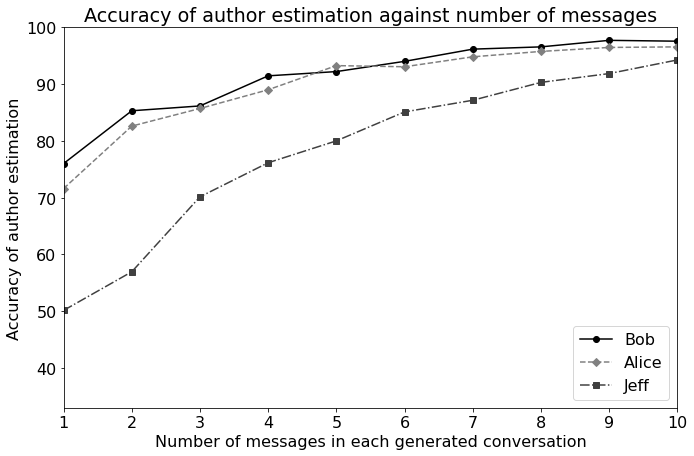

In [7]:

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=11, h=7)
styles = ['-o', '--D', '-.s']
colors = [0.0, 0.5, 0.25]
for index, person in enumerate(gt_people):
    results = result_accuracies[person.name]
    col = colors[index]
    ax.plot(range(1, 11), results, styles[index], color=(col, col, col), label=person.name)

ax.legend(loc='lower right')
ax.set_title("Accuracy of author estimation against number of messages")
ax.set_xlim(1, 10)
ax.set_xlabel("Number of messages in each generated conversation")
ax.set_ylim(33, 100)
_ = ax.set_ylabel("Accuracy of author estimation")


**Discussion**
These results demonstrate that Tyche provides an effective means of estimating the author of messages when only given their writing tendencies. When only a single message is provided, we are able to estimate if Bob authored a message with 77% accuracy. This is quite an accurate estimate. However, with only a single message, it is harder to determine if Jeff authored a message, with only 50% accuracy for Jeff. This is as expected, as Jeff's writing tendencies are less distinct than Bob's.

However, as the number of messages provided for prediction is increased, our author estimation for all authors also drastically increases. With just 10 messages, we can predict Jeff's messages with 94% accuracy, and Bob's messages with 98% accuracy. This suggests that if you had even larger sets of messages from the same author, then Tyche should be even more accurate at author prediction.

## 6. Learning of Message Writing Tendencies
We use random observations of sets of messages generated from the ground-truth model (termed conversations) to learn the message writing tendencies of each person. This has the goal of estimating the ground-truth model when only supplied with indirect observations from it.

### 6.1. Unbiased Initial Belief Model
We generate an initial belief model to learn using, which is initialised with all probabilities at their default values.

In [8]:
def create_initial_learn_model() -> tuple[Person, Person, Person]:
    """ Constructs the initial model to train from. """
    bob = Person("Bob")
    alice = Person("Alice")
    jeff = Person("Jeff")
    bob.conversed_with.add(alice)
    bob.conversed_with.add(jeff)
    alice.conversed_with.add(bob)
    alice.conversed_with.add(jeff)
    jeff.conversed_with.add(alice)
    jeff.conversed_with.add(bob)
    return bob, alice, jeff


### 6.2. Learn using Generated Observations
We run several trials where we start with the initial learning model, and train it using randomly generated observations.

In [9]:
no_trials = 10
no_observations_per_trial = 500

# We generate 'conversations' of a small number of messages.
min_messages = 2
max_messages = 4

print(f"Running with {no_trials} trials, {no_observations_per_trial} observations per trial, "
      f"and conversations of {min_messages} to {max_messages} messages")
trial_results = []
example_observations = []
for trial_no in range(no_trials):
    print(f".. running trial {trial_no + 1}")

    learn_people = list(create_initial_learn_model())
    learn_people_by_name: dict[str, Person] = {person.name: person for person in learn_people}

    # Generate random indirect observations about Bob, Alice, and Jeff.
    for _ in range(no_observations_per_trial):
        # The context person is the person that we observed having a conversation with someone.
        gt_recipient = gt_people[random.randint(0, len(gt_people) - 1)]
        learn_recipient = learn_people_by_name[gt_recipient.name]

        # Sample the messages of the conversation.
        partner = cast(Person, gt_recipient.conversed_with.sample())
        conversation = generate_conversation_observation(partner, random.randint(min_messages, max_messages))
        observation = Expectation("conversed_with", conversation)
        if len(example_observations) < 10:
            example_observations.append(f"Observe at {gt_recipient.name}:\n{str(observation)}")

        # Apply the observation to the learned ctx person.
        learn_recipient.observe(observation)

    trial_results.append(learn_people_by_name)


Running with 10 trials, 500 observations per trial, and conversations of 2 to 4 messages
.. running trial 1
.. running trial 2
.. running trial 3
.. running trial 4
.. running trial 5
.. running trial 6
.. running trial 7
.. running trial 8
.. running trial 9
.. running trial 10


In [10]:
print("Example Observations:\n")
print("\n\n".join(example_observations))

Example Observations:

Observe at Jeff:
[conversed_with](((((¬uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive) ∧ ((¬uses_emoji ∧ capitalises_first_word) ∧ is_positive)) ∧ ((¬uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive)))

Observe at Bob:
[conversed_with](((((¬uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive) ∧ ((¬uses_emoji ∧ ¬capitalises_first_word) ∧ ¬is_positive)) ∧ ((¬uses_emoji ∧ capitalises_first_word) ∧ is_positive)))

Observe at Jeff:
[conversed_with](((((uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive) ∧ ((uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive)) ∧ ((uses_emoji ∧ ¬capitalises_first_word) ∧ ¬is_positive)))

Observe at Alice:
[conversed_with]((((¬uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive) ∧ ((¬uses_emoji ∧ ¬capitalises_first_word) ∧ ¬is_positive)))

Observe at Bob:
[conversed_with]((((((uses_emoji ∧ ¬capitalises_first_word) ∧ is_positive) ∧ ((uses_emoji ∧ capitalises_first_word) ∧ ¬is_positive)) ∧ ((¬uses_emoji ∧ capitalises_first_word) 

### 6.3. Resulting Learnt People

In [11]:
feature_concepts = [Concept(c) for c in ["capitalises_first_word", "is_positive", "uses_emoji"]]

print("Ground-Truth People:")
for p in gt_people:
    print(f"- {p.name}(" + ", ".join(f"{c}={p.eval(c):.3f}" for c in feature_concepts) + ")")

Ground-Truth People:
- Bob(capitalises_first_word=0.400, is_positive=0.150, uses_emoji=0.900)
- Alice(capitalises_first_word=0.800, is_positive=0.400, uses_emoji=0.100)
- Jeff(capitalises_first_word=0.500, is_positive=0.500, uses_emoji=0.500)


In [12]:
print("Learnt People:")
for target in gt_people:
    learned = [people[target.name] for people in trial_results]
    learned_uses_emoji = [p.uses_emoji() for p in learned]
    learned_capitalises = [p.capitalises_first_word() for p in learned]
    learned_is_positive = [p.is_positive() for p in learned]
    print(f"- {target.name}("
          f"capitalises_first_word={np.mean(learned_capitalises):.3f} ± {np.std(learned_capitalises):.3f}, "
          f"is_positive={np.mean(learned_is_positive):.3f} ± {np.std(learned_is_positive):.3f}, "
          f"uses_emoji={np.mean(learned_uses_emoji):.3f} ± {np.std(learned_uses_emoji):.3f})")

Learnt People:
- Bob(capitalises_first_word=0.361 ± 0.033, is_positive=0.143 ± 0.032, uses_emoji=0.887 ± 0.025)
- Alice(capitalises_first_word=0.788 ± 0.023, is_positive=0.363 ± 0.046, uses_emoji=0.138 ± 0.033)
- Jeff(capitalises_first_word=0.549 ± 0.051, is_positive=0.469 ± 0.036, uses_emoji=0.461 ± 0.053)


**Discussion**
From the results above, we can see that Tyche is able to quite accurately learn the writing tendencies of each author without knowing for certain which messages they wrote. This learning is based solely upon the initial knowledge in the model that each person would not have received a message written by themselves. There is some error in these results, although the error does decrease as the number of observations is increased.

It can be observed that the standard deviation in the estimations of the writing tendencies of Jeff are significantly higher than those of Bob and Alice. This is likely due to Jeff having the least unique characteristics of the three individuals. Jeff falls between Bob and Alice in the value of all their concepts, and as such we are more likely to confuse Jeff for Bob or Alice than to confuse Bob for Alice or vice versa.


## 7. Conclusion
These results demonstrate the efficacy of Tyche for use in the de-anonymisation of messages, when only the recipient of the messages is known. This result demonstrates that Tyche is an effective tool at extracting knowledge from indirect observations about the world. Therefore, we hope that Tyche may assist in the discovery of unintuitive or unclear relationships within complex datasets.